In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
df_VWCE=pd.read_csv('vwce.csv')
df_SP500=pd.read_csv('sp500.csv')
df_APPLE=pd.read_csv('apple.csv')
df_MSCI=pd.read_csv('msci.csv')
df_EIMI=pd.read_csv("eimi.csv")
sns.set(style="darkgrid")

Data Loading and Cleaning section. Merging to all-in-one fataframe.

In [2]:
# Date conversion for every dataframe 
dfs = [df_VWCE, df_SP500, df_MSCI, df_EIMI,df_APPLE]
ordered_dfs = []

for df in dfs:
    df['Date'] = pd.to_datetime(df['Date'])
    ordered_dfs.append(df.sort_values(by='Date', ascending=True).copy())

df_VWCE_ordered, df_SP500_ordered, df_MSCI_ordered, df_EIMI_ordered, df_APPLE_ordered = ordered_dfs

In [3]:
dfs = [df_VWCE_ordered, df_SP500_ordered, df_MSCI_ordered, df_EIMI_ordered, df_APPLE_ordered]

# Setting date as index
for df in dfs:
    df.set_index('Date', inplace=True)

    # Removing % symbol and convert to float
for df in dfs:
    df['Change %'] = df['Change %'].replace('%', '', regex=True)  # Rimuove '%'
    df['Change %'] = df['Change %'].astype(float)  # Converte in float

In [4]:
# The Sp500 CSV uses ',' as separator, i need to replace it as i want a float value
columns_to_edit = ['Price', 'Open', 'High', 'Low']
for col in columns_to_edit:
    df_SP500_ordered[col] = df_SP500_ordered[col].str.replace(',', '').astype(float)

In [5]:
scaler=MinMaxScaler()
dfs2 = [df_APPLE_ordered, df_VWCE_ordered, df_SP500_ordered, df_MSCI_ordered, df_EIMI_ordered]
columns = ['Price', 'Price', 'Price', 'Price', 'Price']  # Colonna 'Price' per tutti tranne MSCI

# Aggiungiamo la colonna 'Normalized Price' per MSCI separatamente
for i, df in enumerate(dfs2):
    # Normalizzare i prezzi
    df['Normalized Price'] = scaler.fit_transform(df[[columns[i]]])

# Normalizzazione della colonna per MSCI
df_MSCI_ordered['Normalized Price_MSCI'] = scaler.fit_transform(df_MSCI_ordered[['Price']])

In [6]:
df_MSCI_ordered = df_MSCI_ordered.rename(columns={'Normalized Price': 'Normalized Price_MSCI'})
df_merged = df_VWCE_ordered[['Normalized Price']].merge(df_SP500_ordered[['Normalized Price']], left_index=True, right_index=True, suffixes=('_VWCE', '_SP500'))
df_merged = df_merged.merge(df_MSCI_ordered[['Normalized Price_MSCI']], left_index=True, right_index=True)
df_merged = df_merged.merge(df_APPLE_ordered[['Normalized Price']], left_index=True, right_index=True)

df_MSCI_ordered = df_MSCI_ordered.rename(columns={'Price': 'Price_MSCI'})
df_merged2 = df_VWCE_ordered[['Price']].merge(df_SP500_ordered[['Price']], left_index=True, right_index=True, suffixes=('_VWCE', '_SP500'))
df_merged2 = df_merged2.merge(df_MSCI_ordered[['Price_MSCI']], left_index=True, right_index=True)
df_merged2 = df_merged2.merge(df_APPLE_ordered[['Price']], left_index=True, right_index=True)

Exploratory Data Analysis

In [7]:
#Check correlation between VWCE and Sp500
df_VWCE_ordered['Price'].corr(df_SP500_ordered['Price'])

#As we could expect, almost perfect correlation

np.float64(0.9844308436898617)

Text(0, 0.5, 'Price SP500')

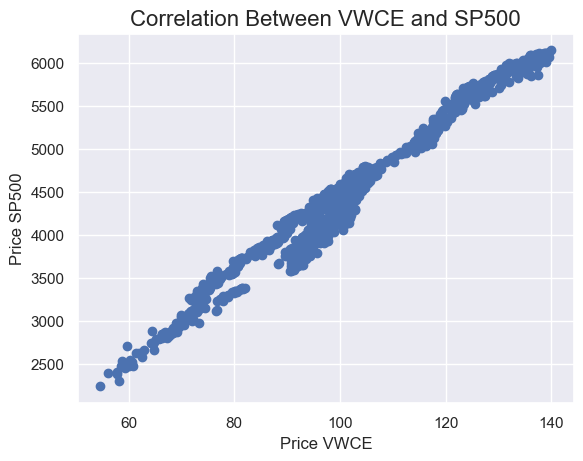

In [8]:
plt.scatter(df_merged2['Price_VWCE'], df_merged2['Price_SP500'])
plt.title("Correlation Between VWCE and SP500", fontsize=16)
plt.xlabel("Price VWCE", fontsize=12)
plt.ylabel("Price SP500", fontsize=12)

#As the result of the concentration of US stocks in FTSE-All World, we can see a nearly perfect positive correlation

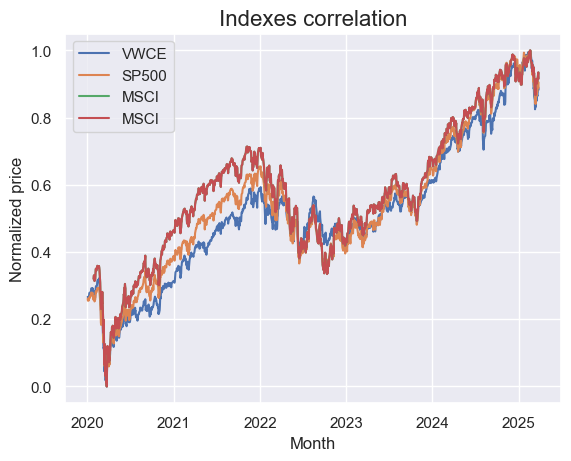

In [9]:
plt.plot(df_VWCE_ordered.index, df_VWCE_ordered['Normalized Price'], label="VWCE")
plt.plot(df_SP500_ordered.index, df_SP500_ordered['Normalized Price'], label="SP500")
plt.plot(df_MSCI_ordered.index, df_MSCI_ordered['Normalized Price_MSCI'], label="MSCI")
plt.title("Indexes correlation", fontsize=16)
plt.xlabel("Month", fontsize=12)
plt.ylabel("Normalized price", fontsize=12)
plt.legend()
plt.show()

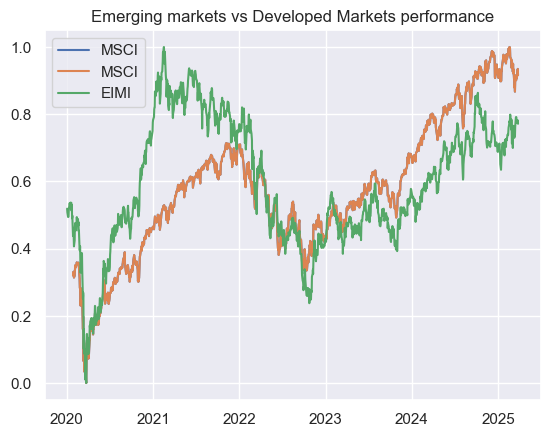

In [10]:
#Looking at emerging markets and developed markets correlation: they are very correlated but EIMI has higher volatility.
#  Are we really diversifing? The rule is to invest in different countries, but what if they move the same?

plt.plot(df_MSCI_ordered.index, df_MSCI_ordered['Normalized Price_MSCI'], label="MSCI")
plt.plot(df_EIMI_ordered.index, df_EIMI_ordered['Normalized Price'], label="EIMI")
plt.title("Emerging markets vs Developed Markets performance")
plt.legend()
plt.show()

<Axes: >

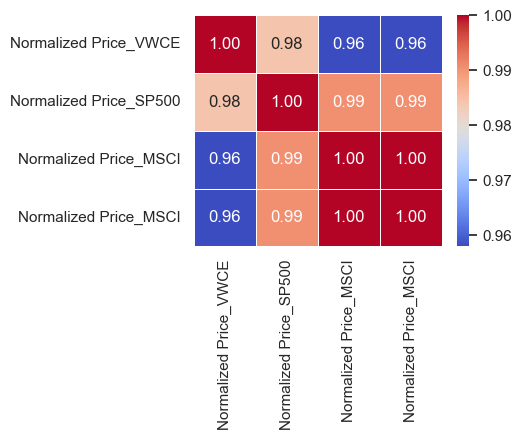

In [11]:
#Heat map confirms the correlation between indexes

corr_matrix = df_merged[['Normalized Price_VWCE', 'Normalized Price_SP500', 'Normalized Price_MSCI']].corr()
plt.figure(figsize=(4, 3)) 
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)

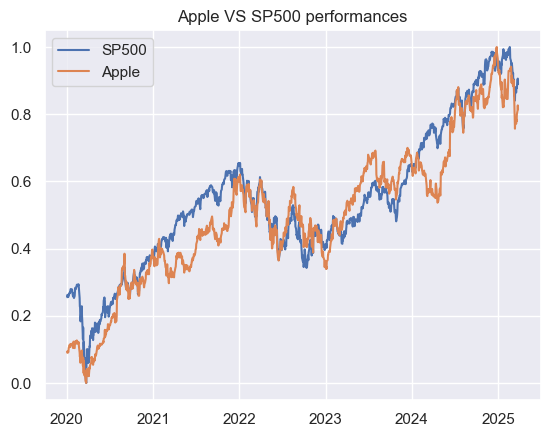

In [12]:
plt.plot(df_SP500_ordered.index, df_SP500_ordered['Normalized Price'], label="SP500")
plt.plot(df_APPLE_ordered.index, df_APPLE_ordered['Normalized Price'], label="Apple")
plt.title("Apple VS SP500 performances")
plt.legend()
plt.show()

#The graphic shows Apple matches the index most of the time, with highter volatily. The stocks clearly suffers (and enjoys, depend of the result) the quarterly earnings.

In [13]:
VWCE_volatility = df_VWCE_ordered['Change %'].std()
SP500_volatility = df_SP500_ordered['Change %'].std()
APPLE_volatility = df_APPLE_ordered['Change %'].std()
MSCI_volatility = df_MSCI_ordered['Change %'].std()
print(VWCE_volatility,MSCI_volatility,SP500_volatility,APPLE_volatility)
#We can clearly see the volatily of the apple stock is more than the double of VWCE ande almost double of SP500/MSCI. This happens beacuse the all world ETF is less concentrated in big tech stocks
#VWCE has less returns but also less volatility, resulting a good product for risk-averse people.

1.0436823585697312 1.2684774544595159 1.33151411053487 1.988734384788778


Prediction Systems: linear regression, MLP and LSTM 

Slope (m): [0.02365335]
Intercept (b): 20.44813654077457
(R^2): 0.9810527396975216


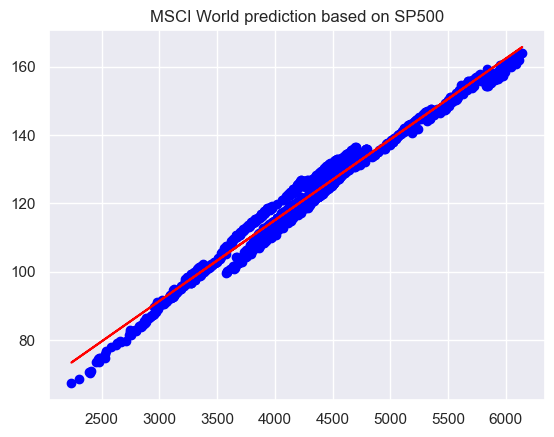

In [14]:
#Let's doing some prediction using a linear regression. We can predict the MSCI world price using the SP500's one.

x = df_merged2[['Price_SP500']]  
y = df_merged2['Price_MSCI']   

model = LinearRegression()
model.fit(x, y)
print(f"Slope (m): {model.coef_}")
print(f"Intercept (b): {model.intercept_}")

y_pred = model.predict(x)

r2_score = model.score(x, y)
print(f"(R^2): {r2_score}")
plt.scatter(x, y, color='blue', label='Data') 
plt.plot(x, y_pred, color='red', label='Regression')
plt.title('MSCI World prediction based on SP500')
plt.show()

In [15]:
new_sp500_price = 5770  # new SP500 price
predicted_msc_price = model.coef_ * new_sp500_price + model.intercept_
print(f"Predicted price for MSCI World = {new_sp500_price} è: {predicted_msc_price}")

Predicted price for MSCI World = 5770 è: [156.92797037]


In [16]:
#Some deep learning: MLP

X = df_merged2[['Price_VWCE', 'Price_SP500']].values  # Input
y = df_merged2['Price_MSCI'].values  # Target 

# Convert to tensor
X_tensor = torch.tensor(X, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.float32).view(-1, 1)  # Target deve essere una colonna

class SimpleModel(nn.Module):
    def __init__(self):
        super(SimpleModel, self).__init__()
        self.fc1 = nn.Linear(2, 64)  #input
        self.fc2 = nn.Linear(64, 32)  #hidden layer
        self.fc3 = nn.Linear(32, 1)   # Un output

    def forward(self, x):
        x = torch.relu(self.fc1(x)) 
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x
model = SimpleModel()

# Loss and optimization function
criterion = nn.MSELoss() 
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training
epochs = 500

for epoch in range(epochs):
    model.train()
    
    outputs = model(X_tensor)
    loss = criterion(outputs, y_tensor)

    # Backpropagation and optiomization
    optimizer.zero_grad()  
    loss.backward()  
    optimizer.step() 

    if (epoch + 1) % 100 == 0:  # print loss value
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')

prezzo1_input = 130.6
prezzo2_input = 5776.25


input_data = torch.tensor([[prezzo1_input, prezzo2_input]], dtype=torch.float32)

#prediction
model.eval() 
predizione = model(input_data)

print(f"Predizione: {predizione.item():.2f}")

Epoch [100/500], Loss: 21.4065
Epoch [200/500], Loss: 21.3566
Epoch [300/500], Loss: 21.3175
Epoch [400/500], Loss: 21.2701
Epoch [500/500], Loss: 21.2151
Predizione: 162.78


In [17]:
#LSTM: neural network for time series prediction

def create_sequence(df, window_size):
    X, y = [], []
    for i in range(window_size, len(df)):
        X.append(df[i-window_size:i, :])  # previous data, window
        y.append(df[i, :])  # future value
    return np.array(X), np.array(y)

data = df_merged2[['Price_VWCE', 'Price_SP500', 'Price_MSCI']].values

# data normalization
scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(data)

window_size = 90
X, y = create_sequence(data_scaled, window_size)

# training and test split
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Convert to tensor
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)


class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_layer_size, output_size):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_layer_size, batch_first=True)
        self.fc = nn.Linear(hidden_layer_size, output_size)

    def forward(self, x):
        out, (hn, cn) = self.lstm(x)
        out = self.fc(out[:, -1, :]) 
        return out

# Parameters
input_size = 3  # (prices of VWCE, SP500, MSCI)
hidden_layer_size = 128
output_size = 3  # (future prices for VWCE, SP500, MSCI)

# Create LSTM model
model = LSTMModel(input_size, hidden_layer_size, output_size)

# Loss and optimization function
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training
epochs = 500
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()

    outputs = model(X_train)
    loss = criterion(outputs, y_train)

    loss.backward()
    optimizer.step()

    if (epoch + 1) % 100 == 0:
        print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item()}")

# Prediction
model.eval()
with torch.no_grad():
    predictions = model(X_test)

# back to values from normalized
predictions = scaler.inverse_transform(predictions.numpy())
y_test = scaler.inverse_transform(y_test.numpy())

num_predictions_to_show = 3  

for i in range(min(num_predictions_to_show, len(predictions))): 
    print(f"Prediction{i+1}:")
    print(f"  Predicted value: VWCE={predictions[i][0]:.2f}, SP500={predictions[i][1]:.2f}, MSCI={predictions[i][2]:.2f}")
    print(f"  Expected value: VWCE={y_test[i][0]:.2f}, SP500={y_test[i][1]:.2f}, MSCI={y_test[i][2]:.2f}")

last_window = data_scaled[-window_size:]  # window
last_window = torch.tensor(last_window, dtype=torch.float32).unsqueeze(0)  # batch

model.eval()
with torch.no_grad():
    future_prediction = model(last_window)

future_prediction = scaler.inverse_transform(future_prediction.numpy())

# Predict March
print("\nNext month prediction (March 2025):")
print(f"  Previsione: VWCE={future_prediction[0][0]:.2f}, SP500={future_prediction[0][1]:.2f}, MSCI={future_prediction[0][2]:.2f}")

Epoch 100/500, Loss: 0.0014245049096643925
Epoch 200/500, Loss: 0.0009696381166577339
Epoch 300/500, Loss: 0.0007639490067958832
Epoch 400/500, Loss: 0.00036925950553268194
Epoch 500/500, Loss: 0.0003256622585467994
Prediction1:
  Predicted value: VWCE=118.44, SP500=5265.35, MSCI=143.74
  Expected value: VWCE=117.08, SP500=5202.39, MSCI=143.72
Prediction2:
  Predicted value: VWCE=118.39, SP500=5261.53, MSCI=143.62
  Expected value: VWCE=116.60, SP500=5209.91, MSCI=143.83
Prediction3:
  Predicted value: VWCE=118.31, SP500=5257.84, MSCI=143.52
  Expected value: VWCE=117.04, SP500=5160.64, MSCI=142.24

Next month prediction (March 2025):
  Previsione: VWCE=133.96, SP500=5870.85, MSCI=154.55



Now let's do something different! Hypotize an investment portfolio in VWCE and find:

    - The return of the investment
    - The compound annual growth ratio
    - Sharpe ratio

In [18]:
initial_investment=10000
n_shares=initial_investment/df_VWCE_ordered['Price'].iloc[0]
total=n_shares*df_VWCE_ordered['Price'].iloc[-1]

print("Total amount of the investing portfolio after 5 years:", total)

Total amount of the investing portfolio after 5 years: 16798.4496124031


In [19]:
monthly_investment = 100  # Investimento mensile
initial_investment = 10000  # Investimento iniziale
investment_values = []
n_shares = initial_investment / df_VWCE_ordered['Price'].iloc[0]

# Add to portfolio
investment_values.append(n_shares * df_VWCE_ordered['Price'].iloc[0])

# Buy shares every 30 days
purchase_interval = 30
current_day = df_VWCE_ordered.index[0]  


for i in range(1, len(df_VWCE_ordered)):
    if (df_VWCE_ordered.index[i] - current_day).days >= purchase_interval:
        price = df_VWCE_ordered['Price'].iloc[i]
        month_shares = monthly_investment / price  # Number of shares you buy this month
        n_shares += month_shares 
        investment_values.append(n_shares * price)  
        current_day = df_VWCE_ordered.index[i]  

    else:
        investment_values.append(n_shares * df_VWCE_ordered['Price'].iloc[i])

df_VWCE_ordered['Investment Value'] = investment_values
print(df_VWCE_ordered[['Price', 'Investment Value']])

             Price  Investment Value
Date                                
2020-01-02   77.40      10000.000000
2020-01-03   77.35       9993.540052
2020-01-06   77.10       9961.240310
2020-01-07   77.59      10024.547804
2020-01-08   77.80      10051.679587
...            ...               ...
2025-03-20  128.74      25001.030687
2025-03-21  128.38      24931.119462
2025-03-24  130.46      25335.050982
2025-03-25  130.60      25362.238680
2025-03-26  130.02      25249.603930

[1335 rows x 2 columns]


Text(0, 0.5, 'Value')

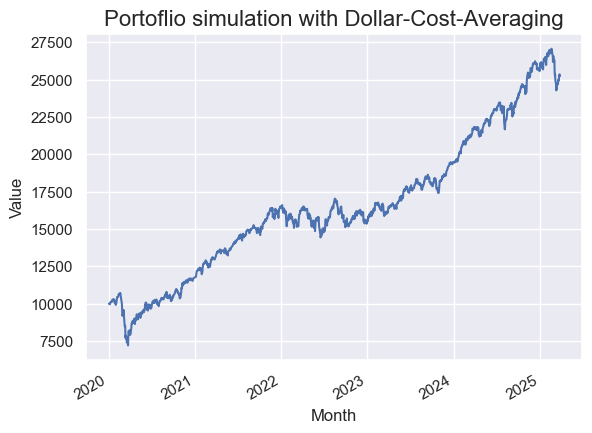

In [20]:
df_VWCE_ordered['Investment Value'].plot(kind='line')
plt.title("Portoflio simulation with Dollar-Cost-Averaging", fontsize=16)
plt.xlabel("Month", fontsize=12)
plt.ylabel("Value", fontsize=12)

#The chart suggests that dollar-cost averaging makes the portfolio growth more stable. Good for risk-aver people

In [21]:
#Now some statistics! Sharpe ratio, ROI and CAGR

#CAGR
num_rows = len(df_VWCE_ordered)
CAGR=((df_VWCE_ordered['Investment Value'].iloc[-1]/initial_investment)**0.2)-1
print(CAGR)

0.2035133554225783


In [22]:
#Return on investment
total_investment=initial_investment+monthly_investment*(len(df_VWCE_ordered)/30)
ROI=(df_VWCE_ordered['Investment Value'].iloc[-1]-total_investment)/total_investment*100
print(ROI) 

#Almost 75% of ROI, good one

74.73774345915703


In [23]:
#Monthly sharpe ratio

mean_return = df_VWCE_ordered['Change %'].mean()
std_deviation = df_VWCE_ordered['Change %'].std()
risk_free_rate = 0.00001 #As hypotesis i use German Bund: 2.5%-year
sharpe_ratio_giornaliero = (mean_return - risk_free_rate) / std_deviation
sharpe_ratio_annualized = sharpe_ratio_giornaliero * np.sqrt(252*5)
print(sharpe_ratio_annualized)

#This sharpe ratio suggests we are in a bull market, the stock market performs well even though Bonds have been high cause of BCE and FED interest rate to fight inflation

1.5121854194844953
